In [1]:
import numpy as np
import pandas as pd
import operator
import collections
import itertools

In [2]:
word_list = list("etainoshrd")
file = open('model//feature-params.txt', 'r') 
lines = file.readlines() 
feature_params=[[0 for i in range(321)] for j in range(10)]
i =0
for line in lines:
    feature_params[i] = [float(x) for x in line.split()]
    i+=1

In [3]:
with open('data//test_words.txt','r') as text_test_words:
    test_word_labels=text_test_words.read().split()
with open('data//train_words.txt','r') as text_train_words:
    train_word_labels=text_train_words.read().split()

In [4]:
def get_feature_test_images():
    feature_test_images = []
    for i in range(1,len(test_word_labels)+1):
        word_vector = []
        word_file = open('data//test_img'+str(i)+".txt",'r')
        for line in word_file:
            word_vector.append([int(x) for x in line.split()])
        feature_test_images.append(word_vector)
    return feature_test_images

def get_feature_train_images():
    feature_train_images = []
    for i in range(1,len(train_word_labels)+1):
        word_vector=[]
        word_file = open('data//train_img'+str(i)+".txt",'r')
        for line in word_file:
            word_vector.append([int(x) for x in line.split()])
        feature_train_images.append(word_vector)
    return feature_train_images

feature_test_images = get_feature_test_images()
feature_train_images = get_feature_train_images()
        

In [5]:
def compute_node_potential_all_labels(word_features,feature_params):
    node_potentials = []
    for j in range(len(word_features)):
        output = []
        for i in range(len(word_list)):
            output.append(np.exp(np.dot(word_features[j],feature_params[i])))
        node_potentials.append(output)
    return node_potentials


In [6]:
transition_params=np.loadtxt("model//transition-params.txt")
transition_params.shape

(10, 10)

In [7]:
def compute_node_potential(word_features,word_label,feature_params):
    node_potential = [0]*len(word_label)
    for i,char in enumerate(word_label):
        node_potential[i]=np.dot(word_features[i],feature_params[word_list.index(char)])
    return np.exp(node_potential)
compute_node_potential(feature_test_images[0],test_word_labels[0],feature_params)

array([1.04885517e+08, 2.20913251e+01, 2.92388248e+07, 4.50596498e+10])

In [8]:
def energy(word_features,word_label,feature_params,transition_params):
    node_potential = np.sum(np.log(compute_node_potential(word_features,word_label,feature_params)))
    transition_potential = np.sum(compute_word_transition_potential(word_label,transition_params))
    #print("Energy",node_potential+transition_potential)
    return node_potential+transition_potential

In [9]:
def compute_word_transition_potential(word_label,transition_params):
    potential = [0]*(len(word_label)-1)
    for i in range(len(word_label)-1):
        potential[i]=transition_params[word_list.index(word_label[i])][word_list.index(word_label[i+1])]
    return potential
        
compute_word_transition_potential(test_word_labels[0],transition_params)    

[0.365483, 0.047337, 0.28069]

In [28]:
def compute_node_potential_word(word_feature,feature_params):
    return np.exp(word_feature @ feature_params.T)

def message_passing(word_features,feature_params,transition_params):
    potential = compute_node_potential_word(word_features, np.array(feature_params))
    trans_potens = np.exp(transition_params)
    
    seq_len = len(word_features)
    m = dict()
    m[seq_len+1,seq_len] = np.ones(10)
    m[0,1] = np.ones(10)
    # backwards messages
    for i in range(seq_len,1,-1):
        j = i-1
        m[i,j] = np.zeros(10)
        for xj in range(10):
            for xi in range(10):
                m[i,j][xj] += potential[i-1][xi] * trans_potens[xj][xi] * m[i+1,i][xi]
    # fw messages
    for i in range(1,seq_len):
        j = i+1
        m[i,j] = np.zeros(10)
        for xj in range(10):
            for xi in range(10):
                m[i,j][xj] += potential[i-1][xi] * trans_potens[xj][xi] * m[i-1,i][xi]
    return m

m = message_passing(feature_test_images[0],feature_params,transition_params)
print("m1->2")
display(pd.DataFrame(np.log(m[1,2]).transpose()).transpose())
print("m2->1")
display(pd.DataFrame(np.log(m[2,1]).transpose()).transpose())
print("m2->3")
display(pd.DataFrame(np.log(m[2,3]).transpose()).transpose())
print("m3->2")
display(pd.DataFrame(np.log(m[3,2]).transpose()).transpose())

m1->2


,0,1,2,3,4,5,6,7,8,9
0,18.589345,17.815295,18.749373,18.522734,18.180753,18.67731,18.091288,18.83407,18.363419,18.216396


m2->1


,0,1,2,3,4,5,6,7,8,9
0,49.592435,49.13302,49.56753,49.522377,49.208489,49.561131,49.016488,49.400556,49.357328,49.150334


m2->3


,0,1,2,3,4,5,6,7,8,9
0,25.651079,25.236859,25.598383,25.577943,25.271637,25.601245,25.07146,25.388027,25.414512,25.202644


m3->2


,0,1,2,3,4,5,6,7,8,9
0,41.809822,42.284232,41.77318,42.223158,42.119828,41.835916,41.754973,42.05085,42.20446,42.070277


In [29]:
def marginal_probability(feature_image, feature_params,m):
    potential = compute_node_potential_all_labels(feature_image,feature_params)
    marginals = np.zeros((len(feature_image),10))
    for i in range(1,len(feature_image)+1):
         marginals[i-1]=potential[i-1][:]*m[i-1,i]*m[i+1,i]
    for i,marginal in enumerate(marginals):
        summation = (np.sum(marginal))
        marginals[i] = marginal/summation 

    return marginals

In [30]:
def pairwise_probability(feature_image,feature_params,transition_params,m):
    potential = compute_node_potential_all_labels(feature_image,feature_params)
    pairwise_prob = np.zeros((len(feature_image)-1,10,10))
    for i in range(1,len(feature_image)):
         forward = (potential[i-1][:]*m[i-1,i]).reshape(1,10) 
         backward = (potential[i][:]*m[i+2,i+1]).reshape(10,1)
         pairwise_prob[i-1]=forward*backward*np.exp(transition_params[:][:])
    for i,pw in enumerate(pairwise_prob):
        summation = np.sum(pw)
        pairwise_prob[i]=pw/summation
    return pairwise_prob

In [31]:
def predict(feature_image,feature_params,transition_params):
    m = message_passing(feature_image,feature_params,transition_params)
    pairwise_prob = np.vstack((np.ones((1,10,10)),pairwise_probability(feature_image,feature_params,transition_params,m)))
    marginal_prob = marginal_probability(feature_image,feature_params,m)
    label = 0
    predicted_sequence = []
    for i in range(len(feature_image)):
        label = np.argmax(pairwise_prob[i,:,label]*marginal_prob[i])
        predicted_sequence.append(label)
    #print(predicted_sequence)
    sequence = ""
    for label in predicted_sequence:
        sequence+=(word_list[label])
    return sequence

In [32]:
def getaccuracy(feature_test_images,params):
    transition_params = params[0:10*10].reshape([10, 10])
    feature_params = params[10*10:].reshape([10, 321])
    true = 0
    total = 0
    for i in range(len(feature_test_images)):
        predicted_label = predict(feature_test_images[i],feature_params,transition_params)
        test_word_label = test_word_labels[i]
        #print(predicted_label,test_word_label)
        for j in range(len(predicted_label)):
            if predicted_label[j]==test_word_label[j]:
                true+=1
            total+=1
    return true/total

In [33]:
def get_log_partition_using_mp(feature_image,word_label,feature_params,transition_params,m):
    potential = compute_node_potential_all_labels(feature_image,feature_params)
    return np.log(np.sum((potential[0]*m[2,1])))

def objective(params,words):
    sum = 0
    for i in range(words):
        sum+=get_loglikelihood_image(feature_train_images[i],train_word_labels[i],params)
    return -sum/words
        
    
def get_loglikelihood_image(feature_image,word_label,params):
    transition_params = params[0:10*10].reshape([10, 10])
    feature_params = params[10*10:].reshape([10, 321])
    m = message_passing(feature_image,feature_params,transition_params)
    sum = energy(feature_image,word_label,feature_params,transition_params)-get_log_partition_using_mp(feature_image,word_label,feature_params,transition_params,m)
    return sum

def get_loglikelihood_test(params):
    transition_params = params[0:10*10].reshape([10, 10])
    feature_params = params[10*10:].reshape([10, 321])
    sum = 0
    for i in range(len(feature_test_images)):
        m = message_passing(feature_test_images[i],feature_params,transition_params)
        sum += energy(feature_test_images[i],test_word_labels[i],feature_params,transition_params)-get_log_partition_using_mp(feature_test_images[i],test_word_labels[i],feature_params,transition_params,m)
    return sum/len(feature_test_images)




In [34]:
def get_derivative(params,words):
    transition_params = params[0:10*10].reshape([10, 10])
    gradient_transition_params = np.zeros([10, 10])
    feature_params = params[10*10:].reshape([10, 321])
    gradient_feature_params = np.zeros([10, 321])
    
    for j in range(words):
        m=message_passing(feature_train_images[j],feature_params,transition_params)
        
        pairwise_marginal=pairwise_probability(feature_train_images[j],feature_params,transition_params,m)
        marginal_distribution=marginal_probability(feature_train_images[j],feature_params,m)
        
        for i in range(0, len(train_word_labels[j])-1):
            label1 = train_word_labels[j][i]
            label2 = train_word_labels[j][i+1]
            gradient_transition_params[word_list.index(label1)][word_list.index(label2)] += 1
            gradient_transition_params -= pairwise_marginal[i].transpose()

        for i in range(0, len(train_word_labels[j])):
            label = train_word_labels[j][i]
            gradient_feature_params[word_list.index(label)][:] += feature_train_images[j][i][:]
            gradient_feature_params -= marginal_distribution[i][:].reshape(10,1)*np.array(feature_train_images[j][i][:]) 
            
    gradient_feature_params = gradient_feature_params.ravel()
    gradient_transition_params = gradient_transition_params.ravel()
    return -np.concatenate([gradient_transition_params,gradient_feature_params]) / words


In [35]:
gradient=get_derivative(np.concatenate([np.array(transition_params).ravel(),np.array(feature_params).ravel()]),50)
tpg = gradient[0:10*10].reshape([10, 10])
fpg = gradient[10*10:].reshape([10, 321])
pd.DataFrame(tpg)

,0,1,2,3,4,5,6,7,8,9
0,0.005308,-0.021359,-0.003917,0.003177,0.000145,0.038527,-0.025373,0.001821,0.006244,-0.004940
1,0.040208,0.000571,0.008149,0.020081,0.046748,-0.035161,0.001719,-0.019778,0.007897,0.034554
2,0.040503,0.020951,0.015171,0.000925,-0.048736,0.028304,-0.057637,-0.006438,-0.020070,0.006431
3,-0.059676,0.000182,-0.000498,0.000707,-0.096035,0.013192,-0.042329,0.033890,0.052356,0.021322
4,-0.017853,-0.036460,-0.018207,0.027898,0.031540,-0.006003,-0.019729,0.010667,0.024252,-0.035624
5,-0.007597,0.021801,0.001838,-0.014670,-0.049537,0.001460,0.006614,0.000177,0.000318,-0.000075
6,-0.019713,-0.002832,-0.006090,-0.024240,0.023340,-0.019425,-0.014788,-0.039986,0.011647,0.000186
7,-0.025744,0.003005,-0.001233,-0.020100,0.014550,-0.019605,0.001062,0.001027,0.017247,0.001190
8,0.053380,0.062798,-0.019763,-0.017357,0.022038,-0.019943,0.027706,0.009307,0.009632,0.012291
9,-0.000924,0.039879,0.018639,-0.040068,0.028730,0.000663,0.005927,0.000941,0.000103,-0.001423


In [36]:
transition_grad=np.loadtxt("model//transition-gradient.txt")
feature_grad=np.loadtxt("model//feature-gradient.txt")
pd.DataFrame(feature_grad)
pd.DataFrame(transition_grad)

,0,1,2,3,4,5,6,7,8,9
0,-0.005308,0.021359,0.003917,-0.003177,-0.000145,-0.038527,0.025373,-0.001821,-0.006244,0.004940
1,-0.040208,-0.000571,-0.008149,-0.020081,-0.046748,0.035161,-0.001719,0.019778,-0.007897,-0.034554
2,-0.040503,-0.020951,-0.015171,-0.000925,0.048736,-0.028304,0.037637,0.006438,0.020070,-0.006431
3,0.059676,-0.000182,0.000498,-0.000707,0.096035,-0.013192,0.042329,-0.033890,-0.052356,-0.021322
4,0.017853,0.036460,0.018207,-0.027898,-0.031540,0.006003,0.019729,-0.010667,-0.024252,0.035624
5,0.007597,-0.021801,-0.001838,0.014670,0.049537,-0.001460,-0.006614,-0.000177,-0.000318,0.000075
6,0.019713,0.002832,0.006090,0.024240,-0.023340,0.019425,-0.005212,0.039986,-0.011647,-0.000186
7,0.025744,-0.003005,0.001233,0.020100,-0.014550,0.019605,-0.001062,-0.001027,-0.017247,-0.001190
8,-0.053380,-0.062798,0.019763,0.017357,-0.022038,0.019943,-0.027706,-0.009307,-0.009632,-0.012291
9,0.000924,-0.039879,-0.018639,0.040068,-0.028730,-0.000663,-0.005927,-0.000941,-0.000103,0.001423


In [42]:
from scipy.optimize import fmin_l_bfgs_b,minimize
import time
words_range = [50,100,150,200,250,300,350,400]
error = []
test_log_likelihood = []
training_time = []
def run():
    for num_word in words_range:
        start = time.time()
        res = minimize(objective,np.zeros(3310), args=(num_word,), jac=get_derivative,method='L-BFGS-B')
        training_time.append(time.time() - start)
        print(res)
        print("Training time:",training_time)
        test_log_likelihood.append(get_loglikelihood_test(res.x))
        print("Test log likelihood:",test_log_likelihood)
        error.append(1-getaccuracy(feature_test_images,res.x))
        print("Error:",error)
        print("Done for", num_word)

run()   

/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/

      fun: 4.078160161213873e-06
 hess_inv: <3310x3310 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.96934086e-12,  1.10913961e-08, -5.25592507e-10, ...,
       -3.06051093e-09, -3.66069408e-09, -9.00730575e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 31
      nit: 24
   status: 0
  success: True
        x: array([-1.04722602, -0.29192364,  0.83584436, ..., -0.34141556,
        1.14732199,  0.05944987])
Training time: [17.982476949691772]
Test log likelihood: [-6.885073478471858]
Error: [0.14893617021276595]
Done for 50
      fun: 7.853615422888538e-05
 hess_inv: <3310x3310 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.22267221e-07, -1.33079679e-08,  7.12490193e-08, ...,
       -1.42658082e-06, -1.39868409e-06, -1.41685334e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 26
      nit: 19
   status: 0
  success: True
        x: array([-1.27670282, -0.11538411,  0.80643319, ...,  0.67094973,
   

/Users/sanchitnevgi/anaconda3/envs/commonsense/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


      fun: 0.0013529138809623192
 hess_inv: <3310x3310 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.70689136e-05,  1.19898822e-03, -4.03080179e-06, ...,
       -9.80292314e-07,  8.41228293e-06, -4.78965217e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 25
      nit: 22
   status: 0
  success: True
        x: array([-1.21354667, -1.34789448,  0.47918262, ...,  0.84078377,
        1.45051138,  1.90187477])
Training time: [17.982476949691772, 32.01008725166321, 51.20850324630737, 61.80397295951843, 71.63987565040588]
Test log likelihood: [-6.885073478471858, -3.4720356617041035, -2.5389032638478772, -2.3158427277937466, -2.169288219022842]
Error: [0.14893617021276595, 0.08140610545790938, 0.08048103607770585, 0.06753006475485657, 0.06382978723404253]
Done for 250
      fun: 0.003671415669167194
 hess_inv: <3310x3310 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.31440289e-05, 7.80541208e-04, 6.73471540e-05, ...,
       3.3905233

In [43]:
print("Training time:",training_time)
print("Test log likelihood:",test_log_likelihood)
print("Error:",error)

Training time: [17.982476949691772, 32.01008725166321, 51.20850324630737, 61.80397295951843, 71.63987565040588, 90.81495714187622, 100.40032005310059, 114.55650591850281]
Test log likelihood: [-6.885073478471858, -3.4720356617041035, -2.5389032638478772, -2.3158427277937466, -2.169288219022842, -1.94794207200139, -1.8058972940903897, -1.7250234756116651]
Error: [0.14893617021276595, 0.08140610545790938, 0.08048103607770585, 0.06753006475485657, 0.06382978723404253, 0.06105457909343204, 0.052728954671600325, 0.04902867715078629]


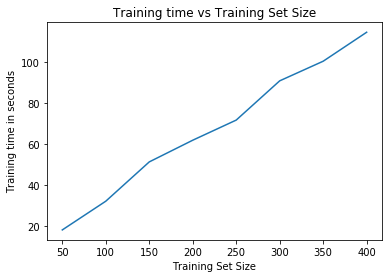

In [44]:
import matplotlib.pyplot as plt  
plt.plot(words_range, training_time) 
fig = plt.gcf()
plt.xlabel('Training Set Size') 
plt.ylabel('Training time in seconds') 
plt.title('Training time vs Training Set Size')  
plt.show() 
fig.savefig('q1.png')

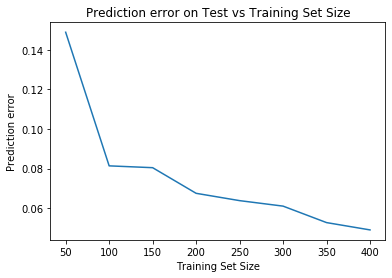

In [45]:
plt.plot(words_range, error) 
fig = plt.gcf()
plt.xlabel('Training Set Size') 
plt.ylabel('Prediction error') 
plt.title('Prediction error on Test vs Training Set Size')  
plt.show() 
fig.savefig('q2.png')

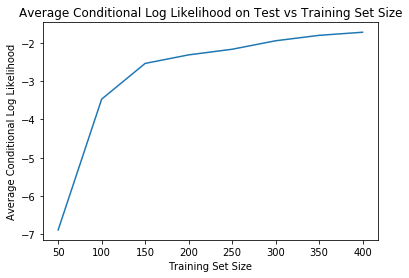

In [41]:
fig = plt.gcf()
plt.plot(words_range, test_log_likelihood) 
plt.xlabel('Training Set Size') 
plt.ylabel('Average Conditional Log Likelihood') 
plt.title('Average Conditional Log Likelihood on Test vs Training Set Size')  
plt.show() 
fig.savefig('q3.png')